# Part 2

### Problem Statement
Train a (simple) penalised linear regression model on the competition data.
- You should use a model from sklearn. You can use Ridge, LASSO or
Elastic Net (or their CV versions).
- For purposes of the competition, your prediction needs to be in the range
0-1. Since you are using linear regression your predictions are likely to fall
outside of this range. You should therefore clip your predictions to fall in
this range.
- You can use the smaller dataset for training and you can choose just a
small number of the features. But you should:
    * Choose at least two numeric variables
    * Spline at least one of the numeric variables that you choose
    * Choose at least one categorical variable and one-hot it
- You should carry out some form of search for the best lambda. It does
not need to be an exhaustive search.
- Predict your model on the test data, clip the predictions to 0-1 and submit
an entry. Take a screen-shot of your entry. Note that you should not
expect a particularly good score.

## Set-up

### Import relevant libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Set directories and paths

In [2]:
# set directories
print(os.getcwd())
dirRawData = os.path.join('..', 'input')
dirPData   = os.path.join('..', 'PData')
dirPOutput = os.path.join('..', 'POutput')

/home/jovyan/smm284-aml/assignment/jimmy


### Load data

In [3]:
# load data: 250k train data
f_name = '01_df_250k.pickle'
f_path = os.path.join(dirPData, f_name)
PData = pickle.load(open(f_path, "rb"))

# separate data into train/test set
train_set = PData['df_train']
test_set = PData['df_test']

In [4]:
# load variable metadata 
f_name = '01_vars.pickle'
f_path = os.path.join(dirPData, f_name)
var_meta = pickle.load(open(f_path, "rb"))

# extract lists from metadata
var_idx_num = var_meta['vars_ind_numeric']
var_idx_cat = var_meta['vars_ind_categorical']
var_idx_hccv = var_meta['vars_ind_hccv']
var_idx_id = var_meta['vars_notToUse']
var_idx_response = var_meta['var_dep']

### Clean missing values

In [5]:
# replace -99 values with np.nan
train_set = train_set.replace(-99, np.nan)
test_set = test_set.replace(-99, np.nan)

In [6]:
# count number of nulls in each column -- train_set
np.array(train_set.isnull().sum(axis = 0))

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0, 102984,
        23788,  23788,  23788,   1852,   2090,  23898,  24321,  11673,
        32806,  33764, 197803,   8895,   6151,  55544,  57869,  57136,
            2,      0,      0,      0,      0,      0,      0,   1092,
            0,      0,      0,      0,      0,      0,      0,      1,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0])

In [7]:
# count number of nulls in each column -- test_set
np.array(test_set.isnull().sum(axis = 0))

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0, 283601,
            0,      0,      0,      0,      0,      2,      0,      1,
            0,      0,      0,      0,      0,      1,      0,      9,
          226,  10870,      9,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,     17, 131970,  26261,
        26261,  26261,   3429,   3504,  26298,  26356,  18076,   2261,
         2356,   2756,  10130,   6363,  18816,  22520,  20432,      2,
            0,      0,      0,      0,      0,      0,   3560,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

Strategy:
- remove the feature if the number of null values in the `test_set` exceed 250
- drop rows that have leftover null values in the `train_set`
- for leftover null values in the `test_set` impute with `mean` for numerical features and `most frequent` for categorical features

Through data exploration, we decided to remove features that have over 250 null values in the test set. That is because imputation can introduce biases to the data as it is impossible to perfectly predict the true values that are missing. Still, it is not possible to remove observations from the test set concerning the competition. We want to preserve as much information as possible, and thus, for features with fewer than 250 null values (less than 0.1% of the data), imputation for mean / most frequent for numeric / categorical features is incorporated as imputing the small number of observations with these values does not have a large impact on the overall distribution.

For the train set, after removing features with over 250 null values in the test set, very small numbers of null values are observed (5 in total). We decided to remove those observations, and thus we only lose 3 observations in total.

In [8]:
# number of null values in the test set exceed 250
to_remove = test_set.columns[np.array(test_set.isnull().sum(axis = 0) > 250)]

In [9]:
# remove the variables
train_set = train_set.drop(columns=to_remove)
test_set = test_set.drop(columns=to_remove)

In [10]:
# display number of leftover missing values in `train_set`
# -- the number of missing value in each column is very small after removing
# -- columns with many null values in the test set
np.array(train_set.isnull().sum(axis = 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
# drop rows that have leftover null values in the `train_set`
train_set = train_set.dropna(axis=0)
print(f'Number of observations in train_set: {len(train_set)}')

Number of observations in train_set: 249997


In [12]:
# display number of leftover missing values in `test_set`
np.array(test_set.isnull().sum(axis = 0))

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2,   0,   1,   0,   0,   0,
         0,   0,   1,   0,   9, 226,   9,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  17,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [13]:
# get columns in the test_set with missing values
impute_col = test_set.columns[np.array(test_set.isnull().sum(axis = 0) > 0)]
impute_col

Index(['c09', 'e03', 'e24', 'e17', 'e18', 'e20', 'f10', 'e02'], dtype='object')

In [14]:
# display data for columns that are going to impute
to_impute = test_set[impute_col]
to_impute.head()

,c09,e03,e24,e17,e18,e20,f10,e02
0,B,A,A,920BD,11250,A4893,CKG,6.0
1,B,A,A,F33BC,5614E,D53C5,AIR,15.0
2,B,A,A,F33BC,5614E,D53C5,AEL,15.0
3,A,A,A,861C8,9076B,A4893,CUO,27.0
4,A,A,A,861C8,9076B,A4893,AWV,27.0


In [15]:
# get column indices for numerical and categorical features that need imputation
num_col = to_impute.select_dtypes(include='number').columns
cat_col = to_impute.select_dtypes(include='category').columns
# create imputation pipeline
# -- parameters = List of (name, transformer, columns)
pipeline = ColumnTransformer([
    ('cat_impute', SimpleImputer(strategy='most_frequent'), cat_col),
    ('num_impute', SimpleImputer(strategy='mean'), num_col)
])
# impute missing values
imputed_test = pipeline.fit_transform(test_set)

In [16]:
# assign values back to the `test_set`
test_set[impute_col] = imputed_test

Check again the number of missing values

In [17]:
print(f'Number of missing values in `train_set`: {np.sum(np.sum(train_set.isna()))}')
print(f'Number of missing values in `test_set`: {np.sum(np.sum(test_set.isna()))}')

Number of missing values in `train_set`: 0
Number of missing values in `test_set`: 0


As some features were removed, we adjust the metadata

In [18]:
var_idx_num = list(set(var_idx_num) - set(to_remove))
var_idx_cat = list(set(var_idx_cat) - set(to_remove))
var_idx_hccv = list(set(var_idx_hccv) - set(to_remove))

### Feature selection


#### - Choose at least two numeric variables 

Select numeric features with LASSO 
- For the parameter tuning, we use 10-Fold CV with 3 repeats. The penalty parameter ($\lambda$) it tuned through automatic search algorith provided by the package as we later select the appropriate $\lambda$ through visualisation.

In [19]:
# get numeric features
X = train_set[var_idx_num]
# get response
y = train_set[var_idx_response].values.ravel()

# scale the variable
scaler = StandardScaler()
X = scaler.fit_transform(X)

# fit a LASSO with cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=999)
lassoCV_ = LassoCV(fit_intercept=True,
                   normalize=False,
                   cv=cv,
                   random_state=999,
                   selection='random',
                   n_jobs=-1, 
                  )
lassoCV_.fit(X=X, y=y)

LassoCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=999), n_jobs=-1,
        random_state=999, selection='random')

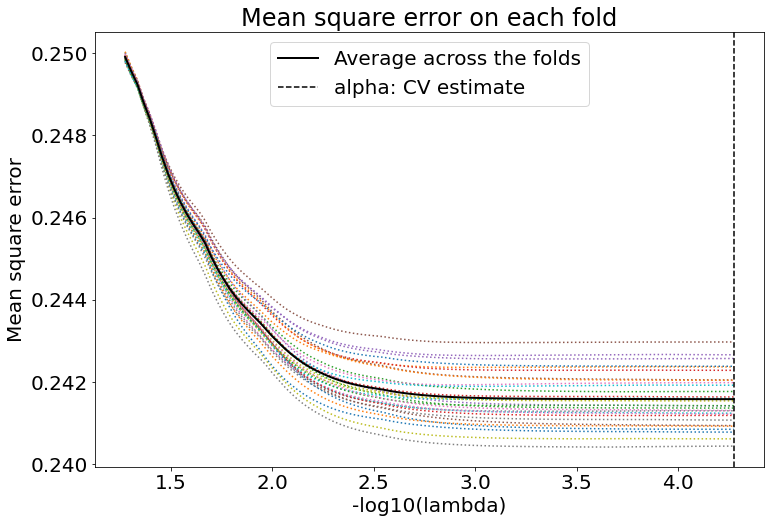

In [20]:
# visualise the relationship between lambda and mse
m_log_lambdas = -np.log10(lassoCV_.alphas_)

font = {'size': 20}
plt.rc('font', **font)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(m_log_lambdas, lassoCV_.mse_path_, ':')
ax1.plot(m_log_lambdas, lassoCV_.mse_path_.mean(axis=-1),
         'k',
         label='Average across the folds',
         linewidth=2)

ax1.axvline(-np.log10(lassoCV_.alpha_),
            linestyle='--', 
            color='k',
            label='alpha: CV estimate')

ax1.legend()

ax1.set_xlabel('-log10(lambda)')
ax1.set_ylabel('Mean square error')
ax1.set_title('Mean square error on each fold')
_ = ax1.axis('tight')

From the above figure, we decided to use the $\lambda$ where $-\log_{10}\lambda = 2.9$ as the MSE is not decreasing much and we favor a simpler model if the evaluation metric is relatively similar.

In [21]:
# specify the lambda
alpha_ = 10**-2.9
# specify the model
lasso_ = Lasso(fit_intercept=True,
               normalize=False,
               alpha=alpha_,
               random_state=999,
              )
# fit the model
lasso_.fit(X=X, y=y)

Lasso(alpha=0.0012589254117941675, random_state=999)

In [22]:
# get selected numeric variables -- coefficients were not penalised to zero
var_sel_num = list(np.array(var_idx_num)[lasso_.coef_ != 0])
print('Selected numerical variables:\n', 
      var_sel_num)

Selected numerical variables:
 ['f21', 'f02', 'f20', 'f08', 'f23', 'f24', 'f18', 'f26', 'f13', 'f16', 'e04', 'e07', 'e08', 'e23', 'f17', 'f19', 'e05', 'e02', 'f01', 'e15', 'f11', 'e06', 'e09', 'f06']


#### - Spline at least one of the numeric variables that you choose

In [23]:
# get selected numeric features from the previous selection
X = train_set[var_sel_num]
# get response
y = train_set[var_idx_response].values.ravel()

In [24]:
# check for unique values
# -- none of them have 1 unique value, 20 seems to be an appropriate cutting point
X.nunique()

f21     4
f02    62
f20     6
f08     5
f23     4
f24     3
f18     4
f26     4
f13    15
f16     4
e04    28
e07     6
e08    21
e23     5
f17     4
f19     4
e05    71
e02    50
f01    17
e15    38
f11    20
e06    13
e09    20
f06    11
dtype: int64

In [25]:
# select only features with 20 or over unique values to spline
var_to_spline = list(X.columns[X.nunique().values >= 20])
print('var_to_spline:\n',
      var_to_spline)

var_to_spline:
 ['f02', 'e04', 'e08', 'e05', 'e02', 'e15', 'f11', 'e09']


In [26]:
# define a spline function
def fn_spline(var, x, n_spline):
    # define percentile step size
    step = 100 // n_spline
    # get the percentiles
    ptiles = np.percentile(x, np.arange(step, 100+step, step))
    # initialise a dataframe
    df_ptiles = pd.DataFrame({var: x})
    # spline the variable
    for idx, ptile in enumerate(ptiles):
        df_ptiles[f'{var}_{str(idx)}'] = np.maximum(0, x - ptiles[idx])
    return [df_ptiles, ptiles]

In [27]:
# perform numeric spline

# initialise a dataframe
df_spline = X.copy()
for var in var_to_spline:
    # generate a dataframe for spline variables
    df_ptiles, knots = fn_spline(var=var, x=X[var], n_spline=5)
    # drop the variable
    df_spline = df_spline.drop(columns=[var])
    # concat the spline variables
    df_spline = pd.concat([df_spline, df_ptiles], axis=1, sort=False)

In [28]:
df_spline.head()

,f21,f20,f08,f23,f24,f18,f26,f13,f16,e07,...,f11_1,f11_2,f11_3,f11_4,e09,e09_0,e09_1,e09_2,e09_3,e09_4
0,0,0,51,0,0,0,0,15.0,0,0,...,5.0,3.0,1.0,0.0,18,0.0,0.0,0.0,0.0,0.0
1,0,0,51,0,0,0,0,9.0,0,0,...,6.0,4.0,2.0,0.0,18,0.0,0.0,0.0,0.0,0.0
2,0,0,51,0,0,0,0,11.0,0,0,...,4.0,2.0,0.0,0.0,18,0.0,0.0,0.0,0.0,0.0
3,0,1,51,0,0,0,0,10.0,1,0,...,1.0,0.0,0.0,0.0,43,25.0,0.0,0.0,0.0,0.0
4,0,0,51,0,0,0,0,9.0,0,0,...,4.0,2.0,0.0,0.0,43,25.0,0.0,0.0,0.0,0.0


perform variable selection with LASSO
 - The hyperparameter tuning process is similar to the previous tuning.

In [29]:
# get features
X = df_spline.copy()
# get response
y = train_set[var_idx_response].values.ravel()

# get the feature columns
spline_col = list(X.columns)

# scale the variable
scaler = StandardScaler()
X = scaler.fit_transform(X)

# fit a LASSO with cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=999)
lassoCV_ = LassoCV(fit_intercept=True,
                   normalize=False,
                   cv=cv,
                   random_state=999,
                   selection='random',
                   n_jobs=-1, 
                  )
lassoCV_.fit(X=X, y=y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2238.6346565478525, tolerance: 6.248045754948859
  model = cd_fast.enet_coordinate_descent(


LassoCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=999), n_jobs=-1,
        random_state=999, selection='random')

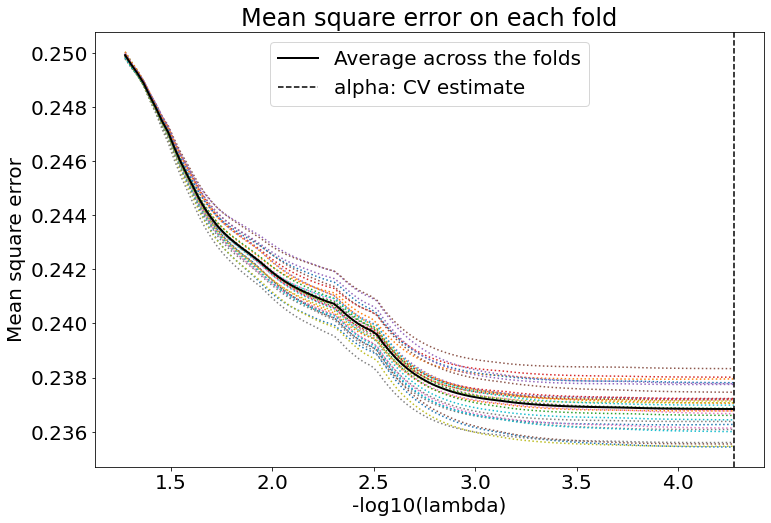

In [30]:
# visualise the relationship between lambda and mse
m_log_lambdas = -np.log10(lassoCV_.alphas_)

font = {'size': 20}
plt.rc('font', **font)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(m_log_lambdas, lassoCV_.mse_path_, ':')
ax1.plot(m_log_lambdas, lassoCV_.mse_path_.mean(axis=-1),
         'k',
         label='Average across the folds',
         linewidth=2)

ax1.axvline(-np.log10(lassoCV_.alpha_),
            linestyle='--', 
            color='k',
            label='alpha: CV estimate')

ax1.legend()

ax1.set_xlabel('-log10(lambda)')
ax1.set_ylabel('Mean square error')
ax1.set_title('Mean square error on each fold')
_ = ax1.axis('tight')

From the above figure, we decided to use the $\lambda$ where $-\log_{10}\lambda = 3$

In [31]:
alpha_ = 10**-3
lasso_ = Lasso(fit_intercept=True,
               normalize=False,
               alpha=alpha_,
               random_state=999,
              )
lasso_.fit(X=X, y=y)

Lasso(alpha=0.001, random_state=999)

In [32]:
# get selected features-- coefficients were not penalised to zero
sel_features_spline = list(np.array(spline_col)[lassoCV_.coef_ != 0])
print('Selected features after spline:\n', 
      sel_features_spline)

Selected features after spline:
 ['f21', 'f20', 'f08', 'f23', 'f24', 'f18', 'f26', 'f13', 'f16', 'e07', 'e23', 'f17', 'f19', 'f01', 'e06', 'f06', 'f02', 'f02_0', 'f02_1', 'f02_3', 'e04', 'e04_0', 'e04_1', 'e04_2', 'e04_3', 'e08', 'e08_0', 'e08_1', 'e08_3', 'e05', 'e05_0', 'e05_1', 'e05_2', 'e05_3', 'e02', 'e02_0', 'e02_2', 'e02_3', 'e15', 'e15_0', 'e15_2', 'e15_3', 'f11', 'f11_0', 'f11_1', 'f11_2', 'f11_3', 'e09_2']


Get a dataframe for numeric (including spline) features 

In [33]:
train_numeric = df_spline[sel_features_spline]
train_numeric.head()

,f21,f20,f08,f23,f24,f18,f26,f13,f16,e07,...,e15,e15_0,e15_2,e15_3,f11,f11_0,f11_1,f11_2,f11_3,e09_2
0,0,0,51,0,0,0,0,15.0,0,0,...,83,61.0,24.0,0.0,14.0,8.0,5.0,3.0,1.0,0.0
1,0,0,51,0,0,0,0,9.0,0,0,...,83,61.0,24.0,0.0,15.0,9.0,6.0,4.0,2.0,0.0
2,0,0,51,0,0,0,0,11.0,0,0,...,83,61.0,24.0,0.0,13.0,7.0,4.0,2.0,0.0,0.0
3,0,1,51,0,0,0,0,10.0,1,0,...,83,61.0,24.0,0.0,10.0,4.0,1.0,0.0,0.0,0.0
4,0,0,51,0,0,0,0,9.0,0,0,...,83,61.0,24.0,0.0,13.0,7.0,4.0,2.0,0.0,0.0


#### - Choose at least one categorical variable and one-hot it

In [34]:
# get categorical features that are not hccv
X = train_set[list(set(var_idx_cat) - set(var_idx_hccv))]
# get response
y = train_set[var_idx_response].values.ravel()

In [35]:
# check for unique values
# -- none of them have 1 unique value
X.nunique()

a16     3
b02     2
b03     2
c05     3
e14     7
c04     3
a12     5
f07     4
a20     2
f29     7
b04     9
f03     7
e24    13
c07     3
f04     2
e21    17
a17     3
a03    12
f27     7
f09    13
a19     2
a13     5
a01     7
a10     3
c06     3
f34     2
e20    26
e22     2
c09     3
f05     5
f30     2
b07     3
e03    13
c08     3
a02     8
f33     2
a18     2
e11     7
e13    15
e01     3
e25     2
dtype: int64

Select categorical variables through tree-based feature importance

In [36]:
# encode the variables with ordinal encoder
ord_enc = OrdinalEncoder()
enc_X = ord_enc.fit_transform(X)

# train tree-based feature selection
model = ExtraTreesClassifier()
model.fit(enc_X, y)
# get the feature importance values
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

In [37]:
# print the feature importances
feat_importances.sort_values(ascending=False)

e21    0.171845
b04    0.109035
f09    0.078853
e20    0.073908
a03    0.065869
e11    0.065408
e13    0.057318
e14    0.047645
a02    0.047270
f03    0.033960
c08    0.022039
f29    0.021925
a16    0.019854
f27    0.017677
e03    0.017552
e24    0.016535
c09    0.015998
f05    0.012963
f04    0.012790
e25    0.011951
f07    0.011582
e01    0.011132
f33    0.008643
a12    0.007038
b02    0.006998
a13    0.005196
a17    0.004638
b07    0.004472
c07    0.003677
a10    0.002801
a01    0.002570
f30    0.002553
f34    0.002271
e22    0.001580
c05    0.001535
a18    0.001318
c04    0.000632
c06    0.000577
a19    0.000241
b03    0.000125
a20    0.000024
dtype: float64

In [38]:
# there is a big leap after the second most important variable, we only select the first two
var_sel_cat = list(feat_importances.sort_values(ascending=False)[:2].index)
print('Selected categorical variables:\n', 
      var_sel_cat)

Selected categorical variables:
 ['e21', 'b04']


One-hot encoding

In [39]:
# define a one-hot encoding function
def fn_onehot(var):
    # get column name
    col_name = var.name
    # get dummies
    df_oh = pd.get_dummies(var, drop_first=False)
    # find the most frequent column
    col_mostFreq = df_oh.sum(axis = 0).idxmax()
    # drop the most frequent column
    df_oh = df_oh.drop(col_mostFreq, axis=1)
    # rename the column
    df_oh.columns = [f'{col_name}_{level}' for level in df_oh.columns]
    return df_oh

In [40]:
# perform one-hot encoding

# initialise a dataframe
df_oh = pd.DataFrame()
for var in var_sel_cat:
    # generate a dataframe for one-hot encoded variable
    df = fn_onehot(X[var])
    # concat the one-hot variables
    df_oh = pd.concat([df_oh, df], axis=1, sort=False)

In [41]:
df_oh.head()

,e21_A,e21_B,e21_D,e21_E,e21_F,e21_G,e21_H,e21_I,e21_J,e21_K,...,e21_P,e21_Q,b04_B,b04_C,b04_D,b04_E,b04_F,b04_G,b04_H,b04_I
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Train and predict with a penalised linear regression model

The above code is to simulate the variable selection and the preprocessing process use in this model. The following code will perform the above preprocessing on both the training set and the test set, train a penalised linear regression model, and make a prediction on the test set.

#### Data preprocessing

Numeric features

In [42]:
# subset df with selected numeric features
df_train_num = train_set[var_sel_num]
df_test_num = test_set[var_sel_num]

Spline numeric features

- Spline using the percentiles from the train set and applies the same transformation to the test set (Similar logic as other preprocessings the transformation is fitted using the training set and applied to the test set).

In [43]:
# define a spline function that transform both train/test set
def fn_spline_train_test(var, x_train, x_test, n_spline):
    # define percentile step size
    step = 100 // n_spline
    # get the percentiles from the train set
    ptiles = np.percentile(x_train, np.arange(step, 100+step, step))
    # initialise dataframes
    train_ptiles = pd.DataFrame({var: x_train})
    test_ptiles = pd.DataFrame({var: x_test})
    # spline the variable
    for idx, ptile in enumerate(ptiles):
        train_ptiles[f'{var}_{str(idx)}'] = np.maximum(0, x_train - ptiles[idx])
        test_ptiles[f'{var}_{str(idx)}'] = np.maximum(0, x_test - ptiles[idx])
    return [train_ptiles, test_ptiles]

In [44]:
# applies linear spline to both train/test sets
for var in var_to_spline:
    # generate a dataframe for spline variables
    train_ptiles, test_ptiles = fn_spline_train_test(var=var, 
                                                     x_train=df_train_num[var],
                                                     x_test=df_test_num[var],
                                                     n_spline=5)
    # drop the variable that were transformed
    df_train_num = df_train_num.drop(columns=[var])
    df_test_num = df_test_num.drop(columns=[var])
    # concat the spline variables
    df_train_num = pd.concat([df_train_num, train_ptiles], axis=1, sort=False)
    df_test_num = pd.concat([df_test_num, test_ptiles], axis=1, sort=False)
# subset the dataframe from selected variables through previous LassoCV
df_train_num = df_train_num[sel_features_spline]
df_test_num = df_test_num[sel_features_spline]

Categorical features

In [45]:
# subset df with selected categorical features
df_train_cat = train_set[var_sel_cat]
df_test_cat = test_set[var_sel_cat]

One-hot encoding
* Some classes in the test set do not exist in the train set. Therefore, we concatenate the two sets for encoding purpose.

In [46]:
# create a `isTrain` column to specify to which df an observation belongs
df_train_cat['isTrain'] = True
df_test_cat['isTrain'] = False
# concatenate the two dataframe
df_all_cat = pd.concat([df_train_cat, df_test_cat], axis=0, sort=False)

<ipython-input-46-a2142dbbf694>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cat['isTrain'] = True
<ipython-input-46-a2142dbbf694>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cat['isTrain'] = False


In [47]:
# initialise a dataframe with `isTrain` column
df_oh = df_all_cat['isTrain']
for var in var_sel_cat:
    # generate a dataframe for one-hot encoded variable
    df = fn_onehot(df_all_cat[var])
    # concat the one-hot variables
    df_oh = pd.concat([df_oh, df], axis=1, sort=False)
    
# assign back to the `df_train_cat` dataframe
df_train_cat = df_oh[df_oh['isTrain'] == True]
# drop the `isTrain` column
df_train_cat = df_train_cat.drop(columns='isTrain')

# assign back to the `df_test_cat` dataframe
df_test_cat = df_oh[df_oh['isTrain'] == False]
# drop the `isTrain` column
df_test_cat = df_test_cat.drop(columns='isTrain')

Concatenate the train/test sets -- numeric and categorical

In [48]:
df_train_all = pd.concat([df_train_num, df_train_cat], axis=1, sort=False)
df_test_all = pd.concat([df_test_num, df_test_cat], axis=1, sort=False)

Concatenate response column to the train set

In [49]:
df_train_all['target'] = train_set[var_idx_response]

Split train set into - train/val set - for hyperparameter tuning

In [50]:
# split train for validation
training_set, val_set = train_test_split(df_train_all, test_size=0.2, random_state=888)

# organize train/test components
X_train = training_set.loc[:, training_set.columns != 'target']
y_train = training_set.loc[:, 'target']
X_val = val_set.loc[:, val_set.columns != 'target']
y_val = val_set.loc[:, 'target']

Standardise numeric features

In [51]:
# get numeric features index -- format required by `ColumnTransformer` function
num_col = X_train[sel_features_spline].columns
# create a pipeline to only standardise numeric columns
# -- parameters = List of (name, transformer, columns)
pipeline = ColumnTransformer([('standardise', StandardScaler(), num_col)])

# fit and transform numeric features through `StandardScaler()`
X_train_scale = pipeline.fit_transform(X_train)
X_val_scale = pipeline.transform(X_val)
df_test_all_scale = pipeline.transform(df_test_all)

# assign back the scaled values
X_train[num_col] = X_train_scale
X_val[num_col] = X_val_scale
df_test_all[num_col] = df_test_all_scale

<ipython-input-51-e32862052ea9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_col] = X_train_scale
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-51-e32862052ea9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

#### Model Training
We tried the two models including:
- Ridge
- LASSO

to see which model would give best result for this data 
- Model comparison metric: roc_auc_score (AUC)

In [52]:
# setup lambdas for grid search
# -- the grid was defined through experiments
lambdas = np.logspace(-3, 2, 10)
# initialise a dataframe to store model results from ridge regressions
df_results_rr = pd.DataFrame({'lambda_': lambdas,
                              'ROC_train': np.nan,
                              'ROC_val': np.nan
                             })

Ridge regression

In [53]:
# ridge regressions
for idx, lambda_ in enumerate(lambdas):
    # specify the model
    model = Ridge(alpha=lambda_,
                  fit_intercept=True,
                  normalize=False,
                  random_state=999)
    # fit the model
    model.fit(X_train, y_train)
    
    # make prediction on the train/validation set
    model_pred_train = model.predict(X_train)
    model_pred_val   = model.predict(X_val)
    
    # compute AUC score
    df_results_rr['ROC_train'][idx] = roc_auc_score(y_train, model_pred_train)
    df_results_rr['ROC_val'][idx]   = roc_auc_score(y_val, model_pred_val)

In [54]:
# print the best model
print(
'Ridge Regression:\n\
---------------------'
)
print(df_results_rr.iloc[df_results_rr['ROC_val'].idxmax()])

# expected result
# -- even with seed set, the psuedorandomness in the model training
# -- does not give the completely same results concerning very small digits
# Ridge Regression:
# ---------------------
# lambda_      100.000000
# ROC_train      0.633029
# ROC_val        0.625490

Ridge Regression:
---------------------
lambda_      100.000000
ROC_train      0.633029
ROC_val        0.625490
Name: 9, dtype: float64


LASSO regression

In [55]:
# setup lambdas for grid search
# -- the grid was defined through experiments
lambdas = np.logspace(-3, 2, 10)
# initialise a dataframe to store model results from LASSO regressions
df_results_lr = pd.DataFrame({'lambda_': lambdas,
                              'ROC_train': np.nan,
                              'ROC_val': np.nan
                             })

In [56]:
# lasso regressions
for idx, lambda_ in enumerate(lambdas):
    # specify the model
    model = Lasso(alpha=lambda_,
                  fit_intercept=True,
                  normalize=False,
                  random_state=999)
    # fit the model
    model.fit(X_train, y_train)
    
    # make prediction on the train/validation set
    model_pred_train = model.predict(X_train)
    model_pred_val   = model.predict(X_val)
    
    # compute AUC score
    df_results_lr['ROC_train'][idx] = roc_auc_score(y_train, model_pred_train)
    df_results_lr['ROC_val'][idx]   = roc_auc_score(y_val, model_pred_val)

In [57]:
# print the best model
print(
'Lasso Regression:\n\
---------------------'
)
print(df_results_lr.iloc[df_results_lr['ROC_val'].idxmax()])

# expected result
# -- even with seed set, the psuedorandomness in the model training
# -- does not give the completely same results concerning very small digits
# Lasso Regression:
# ---------------------
# lambda_      0.001000
# ROC_train    0.630893
# ROC_val      0.622881

Lasso Regression:
---------------------
lambda_      0.001000
ROC_train    0.630893
ROC_val      0.622881
Name: 0, dtype: float64


#### Predict the test set
To predict the test set, we use the model that performed best on the validation set.
- Model used: Ridge regression - $\lambda = 100$

In [58]:
# concatenate the train and validation dataset to provide the most information we have
X_design = pd.concat([X_train, X_val], axis = 0, sort=False)
y_design = pd.concat([y_train, y_val], axis = 0, sort=False)
# specify the model
model = Ridge(alpha=100,
              fit_intercept=True,
              normalize=False,
              random_state=999)
# fit the model
model.fit(X_design, y_design)
# make prediction
model_pred_test = model.predict(df_test_all)
# clip the result to be in range [0, 1]
model_pred_test = np.where(model_pred_test < 0, 0, model_pred_test)
model_pred_test = np.where(model_pred_test > 1, 1, model_pred_test)

#### Create submission file

In [59]:
submission = pd.DataFrame({
    'unique_id': test_set['unique_id'],
    'Predicted': model_pred_test
})
# save the submission file
f_name = 'Group_8_part2.csv'
f_path = os.path.join(dirPOutput, f_name)
submission.to_csv(f_path, index=False)

In [60]:
submission

,unique_id,Predicted
0,6,0.536861
1,16,0.585298
2,17,0.364450
3,18,0.551739
4,19,0.469801
...,...,...
296685,2265630,0.619475
296686,2265631,0.574988
296687,2265632,0.595093
296688,2265637,0.310367


### Note on Part 2

#### Kaggle score: 0.62644
<img src="../screenshots/Group_8_part2_screenshot.png">

For Part 2, the logical processes for our solution are as follows:
- Strategically clean the missing values
- Perform numeric feature selection through LASSO
- Apply linear spline (n=5; equidistant percentile between 0,1) to selected numeric features that have more than 20 unique values
- Perform feature selection again through LASSO to avoid overfitting
- Perform categorical feature selection based on tree-based variable importance (hccv features are not used in this part)
- One-Hot encoded selected categorical variables
- Standardise numeric variables
  * Using mean/sd of the train set for train/val training process
  * Using mean/sd of design set for design/test training process
- Tune and compare between Lasso and Ridge regressions
- Fit the final model on the design set: model = Ridge regression with lambda = 100
- Predict the test set and create the submission file for the Kaggle competition